# CS 599 — Lab 2 Catastrophic Forgetting with MLPs on Permuted-MNIST

Imports

In [ ]:
import os, random
import numpy as np
import tensorflow as tf
from typing import List, Tuple
import matplotlib.pyplot as plt

TF version: 2.19.0


Set configs as well as seeding

In [ ]:
#CONFIG & SEEDING
N_TASKS        = 10                # number of permuted-MNIST tasks
HIDDEN_UNITS   = 256               # units per hidden layer
DEPTHS         = [2, 3, 4]         # number of hidden layers to compare
DROPOUT_PS     = [0.0, 0.2, 0.5]   # <= 0.5 as per assignment
LOSSES         = ["nll", "l1", "l2", "l1+l2"]
OPTIMIZERS     = ["sgd", "adam", "rmsprop"]
SEED           = 546               # Unique seed
EPOCHS_FIRST   = 50                # Task A epochs
EPOCHS_OTHERS  = 20                # Tasks B..J epochs
BATCH_SIZE     = 128               # typical value; adjust as needed
VAL_SPLIT      = 0.1               # hold-out for validation curves
LR             = 1e-3              # Learning rate

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

Load MNIST dataset, make and apply permutations to data set and build tasks

In [ ]:

def load_mnist():
    (xtr, ytr), (xte, yte) = tf.keras.datasets.mnist.load_data()
    xtr = xtr.astype('float32') / 255.0
    xte = xte.astype('float32') / 255.0
    xtr = xtr.reshape((-1, 784))
    xte = xte.reshape((-1, 784))
    return (xtr, ytr), (xte, yte)

def make_permutation(dim: int, seed: int):
    rng = np.random.RandomState(seed)
    return rng.permutation(dim)

def apply_perm(X: np.ndarray, perm: np.ndarray):
    return X[:, perm]

(BASE_XTR, BASE_YTR), (BASE_XTE, BASE_YTE) = load_mnist()

def build_tasks(n_tasks: int, base_seed: int):
    xtr, ytr = BASE_XTR, BASE_YTR
    xte, yte = BASE_XTE, BASE_YTE
    tasks = []
    for t in range(n_tasks):
        perm = make_permutation(784, base_seed + t)
        Xtr_t = apply_perm(xtr, perm)
        Xte_t = apply_perm(xte, perm)
        tasks.append(((Xtr_t, ytr), (Xte_t, yte), perm))
    return tasks

tasks = build_tasks(N_TASKS, SEED)
len(tasks), tasks[0][0][0].shape


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


(10, (60000, 784))

Visualization Help or original data vs permutation

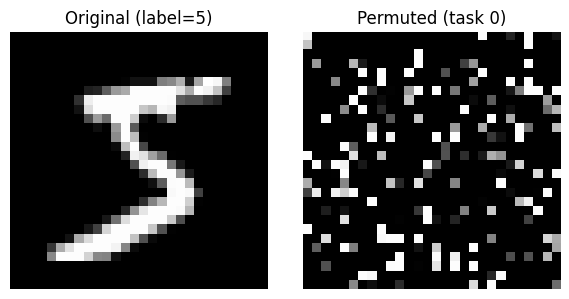

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_original_and_permuted(task_id=0, idx=0, split='train'):
    perm = tasks[task_id][2]

    if split == 'train':
        x_orig = BASE_XTR[idx]
        y_label = int(BASE_YTR[idx])
    else:
        x_orig = BASE_XTE[idx]
        y_label = int(BASE_YTE[idx])

    x_perm = x_orig[perm]

    img_orig = x_orig.reshape(28, 28)
    img_perm = x_perm.reshape(28, 28)

    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    axes[0].imshow(img_orig, cmap='gray', interpolation='nearest')
    axes[0].set_title(f'Original (label={y_label})')
    axes[0].axis('off')

    axes[1].imshow(img_perm, cmap='gray', interpolation='nearest')
    axes[1].set_title(f'Permuted (task {task_id})')
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()

visualize_original_and_permuted(task_id=0, idx=0, split='train')


Make Training and Validation Splits

In [ ]:
def make_tfds(X, y, batch_size = BATCH_SIZE, shuffle=True):
  ds = tf.data.Dataset.from_tensor_slices((X,y))
  if shuffle:
    ds = ds.shuffle(min(10000, len(X)), seed=SEED, reshuffle_each_iteration=True)
  ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
  return ds

def train_val_split(X, y, val_split = VAL_SPLIT):
  n = len(X)
  n_val = int(n * val_split)
  index = np.arange(n)
  rng = np.random.RandomState(SEED)
  rng.shuffle(index)
  val_index = index[:n_val]
  train_index = index[n_val:]

  return ((X[train_index], y[train_index]), (X[val_index], y[val_index]))


Build model as well as Regularizers

In [ ]:
def build_mlp(depth: int, hidden: int = HIDDEN_UNITS, dropout_p: float = 0.0, regularizer=None):
  assert depth in (2,3,4)
  inputs = tf.keras.Input(shape=(784,))
  x = inputs

  for _ in range(depth):
    x = tf.keras.layers.Dense(hidden, activation='relu', kernel_regularizer=regularizer)(x)
    if dropout_p > 0:
      x = tf.keras.layers.Dropout(dropout_p)(x)

  logits = tf.keras.layers.Dense(10, activation=None)(x)
  return tf.keras.Model(inputs, logits)

def make_regularizer(loss_name: str, alpha: float = 1e-4):
  if loss_name.lower() == "l1":
    return tf.keras.regularizers.l1(alpha)
  if loss_name.lower()  == "l2":
    return tf.keras.regularizers.l2(alpha)
  if loss_name.lower()  == "l1+l2":
    return tf.keras.regularizers.l1_l2(l1=alpha, l2=alpha)
  return None

Make optimizers and loss functions

In [ ]:
def make_optimizer(name:str, lr: float = LR):
  if name == "sgd":
    return tf.keras.optimizers.SGD(lr, momentum=0.9)
  if name == "adam":
    return tf.keras.optimizers.Adam(lr)
  if name == "rmsprop":
    return tf.keras.optimizers.RMSprop(lr)
  return None

def make_primary_loss(loss_name: str):
  return tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)


Train model and evaluate

In [ ]:
def train_on_task(model, Xtr, ytr, epochs: int, optimizer, loss_fn, val_split=VAL_SPLIT):
    (Xtr_s, ytr_s), (Xval, yval) = train_val_split(Xtr, ytr, val_split)
    ds_train = make_tfds(Xtr_s, ytr_s, shuffle=True)
    ds_val = make_tfds(Xval, yval, shuffle=False)
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
    hist = model.fit(ds_train, epochs=epochs, validation_data=ds_val, verbose=2)
    return hist.history

def evaluate_on_task(model, Xte, yte) -> float:
    ds_test = make_tfds(Xte, yte, shuffle=False)
    _, acc = model.evaluate(ds_test, verbose=0)
    return float(acc)


Run baseline model training, Compute accuracy

In [ ]:
def run_sequential_training(depth: int, dropout_p: float, loss_name: str, opt_name: str,
                            epochs_first=EPOCHS_FIRST, epochs_others=EPOCHS_OTHERS):
    reg = make_regularizer(loss_name)
    model = build_mlp(depth, HIDDEN_UNITS, dropout_p, regularizer=reg)
    opt = make_optimizer(opt_name, LR)
    loss = make_primary_loss(loss_name)

    R = np.zeros((N_TASKS, N_TASKS), dtype=np.float32)
    histories = []

    for i, task in enumerate(tasks):
        (Xtr, ytr), (Xte, yte), _ = task
        epochs = epochs_first if i == 0 else epochs_others
        hist = train_on_task(model, Xtr, ytr, epochs, opt, loss)
        histories.append(hist)
        for j in range(i + 1):
            (Xtr_j, ytr_j), (Xte_j, yte_j), _ = tasks[j]
            R[i, j] = evaluate_on_task(model, Xte_j, yte_j)

    return model, R, histories

print("\n")
print("Baseline Run: Depth = 3, dropout = 0.2")
model, R, histories = run_sequential_training(depth=3, dropout_p=0.2, loss_name="nll", opt_name="adam")

def compute_ACC(R):
  T = R.shape[0]
  return float(np.mean(R[T-1, :T]))

def compute_BWT(R):
  diag = np.diag(R)
  T = R.shape[0]
  return float(np.mean(R[T-1, :T-1] - diag[:T-1]))

ACC = compute_ACC(R)
BTW = compute_BWT(R)
print(f"ACC = {ACC:.4f}")
print(f"BTW = {BTW:.4f}")


ACC, BWT = compute_ACC(R), compute_BWT(R)
print(f"ACC={ACC:.4f}, BWT={BWT:+.4f}")




Baseline Run: Depth = 3, dropout = 0.2
Epoch 1/50
422/422 - 9s - 21ms/step - accuracy: 0.8944 - loss: 0.3416 - val_accuracy: 0.9545 - val_loss: 0.1374
Epoch 2/50
422/422 - 1s - 3ms/step - accuracy: 0.9588 - loss: 0.1391 - val_accuracy: 0.9680 - val_loss: 0.1059
Epoch 3/50
422/422 - 1s - 3ms/step - accuracy: 0.9686 - loss: 0.1032 - val_accuracy: 0.9692 - val_loss: 0.0889
Epoch 4/50
422/422 - 1s - 3ms/step - accuracy: 0.9731 - loss: 0.0843 - val_accuracy: 0.9722 - val_loss: 0.0930
Epoch 5/50
422/422 - 1s - 2ms/step - accuracy: 0.9784 - loss: 0.0680 - val_accuracy: 0.9748 - val_loss: 0.0830
Epoch 6/50
422/422 - 1s - 2ms/step - accuracy: 0.9809 - loss: 0.0621 - val_accuracy: 0.9747 - val_loss: 0.0810
Epoch 7/50
422/422 - 1s - 3ms/step - accuracy: 0.9831 - loss: 0.0518 - val_accuracy: 0.9753 - val_loss: 0.0859
Epoch 8/50
422/422 - 1s - 2ms/step - accuracy: 0.9851 - loss: 0.0478 - val_accuracy: 0.9777 - val_loss: 0.0804
Epoch 9/50
422/422 - 1s - 2ms/step - accuracy: 0.9857 - loss: 0.0439 -

PLot accuracy matrix and forgetting curves

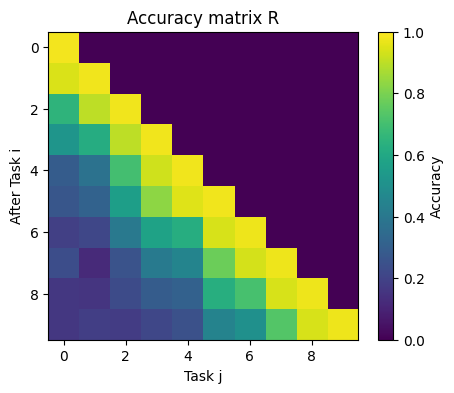

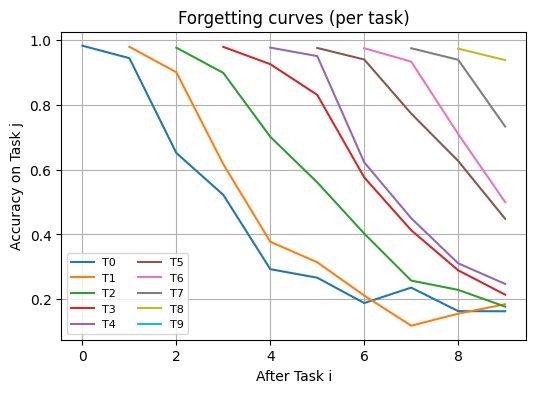

Task 0: forgetting = +0.8208
Task 1: forgetting = +0.7958
Task 2: forgetting = +0.8005
Task 3: forgetting = +0.7658
Task 4: forgetting = +0.7304
Task 5: forgetting = +0.5280
Task 6: forgetting = +0.4757
Task 7: forgetting = +0.2418
Task 8: forgetting = +0.0354
Task 9: forgetting = -0.9745
Mean forgetting: 0.4219699800014496


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5,4))
plt.imshow(R, vmin=0, vmax=1, aspect='auto')
plt.colorbar(label='Accuracy')
plt.xlabel('Task j')
plt.ylabel('After Task i')
plt.title('Accuracy matrix R')
plt.show()

plt.figure(figsize=(6,4))
T = R.shape[0]
for j in range(T):

    xs = np.arange(j, T)
    ys = R[j:T, j]
    plt.plot(xs, ys, label=f'T{j}')
plt.xlabel('After Task i')
plt.ylabel('Accuracy on Task j')
plt.title('Forgetting curves (per task)')
plt.legend(ncol=2, fontsize=8)
plt.grid(True)
plt.show()

F = np.max(R[:-1, :], axis=0) - R[T-1, :]
for j, f in enumerate(F):
    print(f"Task {j}: forgetting = {f:+.4f}")
print("Mean forgetting:", float(np.mean(F)))


Run different experiments

In [ ]:
BASE = dict(depth=3, dropout_p=0.2, loss_name="nll", opt_name="adam")
def eval_config(tag, **kw):
    cfg = BASE | kw
    model, R, _ = run_sequential_training(**cfg)
    ACC, BWT = compute_ACC(R), compute_BWT(R)
    return dict(tag=tag, **cfg, ACC=ACC, BWT=BWT, R_=R)

results = []

# Depth: 2, 3, 4
for d in [2, 3, 4]:
  print(f"Running at Depth: {d}")
  print("\n")
  results.append(eval_config(f"depth_{d}", depth=d))

# Regularizer: none/L1/L2/L1+L2
for reg in ["nll","l1","l2","l1+l2"]:
    print(f"Running at Regularizer: {reg}")
    print("\n")
    results.append(eval_config(f"reg_{reg}", loss_name=reg))

# Dropout: 0.0, 0.2, 0.5
for p in [0.0, 0.2, 0.5]:
    print(f"Running at Dropout: {p}")
    print("\n")
    results.append(eval_config(f"dropout_{p}", dropout_p=p))

# Optimizer: SGD, Adam, RMSProp
for opt in ["sgd","adam","rmsprop"]:
    print(f"Running with Optimizer: {opt}")
    print("\n")
    results.append(eval_config(f"opt_{opt}", opt_name=opt))


Streaming output truncated to the last 5000 lines.
Epoch 46/50
422/422 - -1s - -1476us/step - accuracy: 0.9955 - loss: 0.0168 - val_accuracy: 0.9808 - val_loss: 0.0902
Epoch 47/50
422/422 - 1s - 3ms/step - accuracy: 0.9954 - loss: 0.0156 - val_accuracy: 0.9837 - val_loss: 0.0803
Epoch 48/50
422/422 - 1s - 3ms/step - accuracy: 0.9953 - loss: 0.0166 - val_accuracy: 0.9828 - val_loss: 0.1023
Epoch 49/50
422/422 - 1s - 3ms/step - accuracy: 0.9952 - loss: 0.0158 - val_accuracy: 0.9820 - val_loss: 0.0972
Epoch 50/50
422/422 - 1s - 3ms/step - accuracy: 0.9949 - loss: 0.0178 - val_accuracy: 0.9822 - val_loss: 0.0856
Epoch 1/20
422/422 - 6s - 13ms/step - accuracy: 0.8660 - loss: 0.4477 - val_accuracy: 0.9460 - val_loss: 0.1673
Epoch 2/20
422/422 - 1s - 3ms/step - accuracy: 0.9426 - loss: 0.1943 - val_accuracy: 0.9578 - val_loss: 0.1378
Epoch 3/20
422/422 - 1s - 3ms/step - accuracy: 0.9545 - loss: 0.1521 - val_accuracy: 0.9637 - val_loss: 0.1195
Epoch 4/20
422/422 - 1s - 3ms/step - accuracy: 0.9

Plot accuracy versus experiment config, BWT versus experiment config

        tag  depth  dropout_p loss_name opt_name     ACC       BWT
    depth_2      2        0.2       nll     adam 0.46083 -0.574933
    depth_3      3        0.2       nll     adam 0.43097 -0.607756
    depth_4      4        0.2       nll     adam 0.47624 -0.555578
dropout_0.0      3        0.0       nll     adam 0.34625 -0.698022
dropout_0.2      3        0.2       nll     adam 0.48581 -0.546211
dropout_0.5      3        0.5       nll     adam 0.53441 -0.481967
   opt_adam      3        0.2       nll     adam 0.50314 -0.526800
opt_rmsprop      3        0.2       nll  rmsprop 0.50334 -0.528956
    opt_sgd      3        0.2       nll      sgd 0.86170 -0.121844
     reg_l1      3        0.2        l1     adam 0.20872 -0.852933
  reg_l1+l2      3        0.2     l1+l2     adam 0.20283 -0.856889
     reg_l2      3        0.2        l2     adam 0.19436 -0.870678
    reg_nll      3        0.2       nll     adam 0.46584 -0.568133


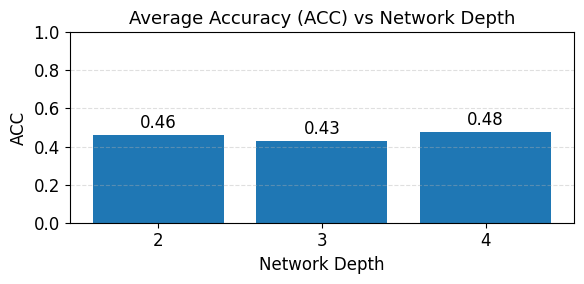

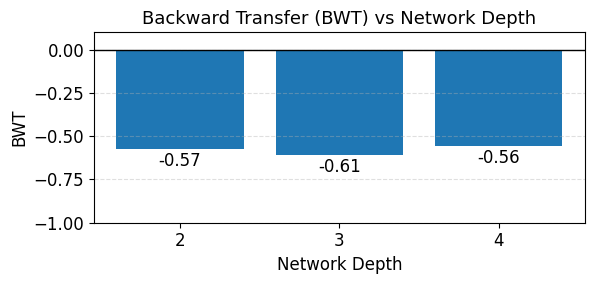

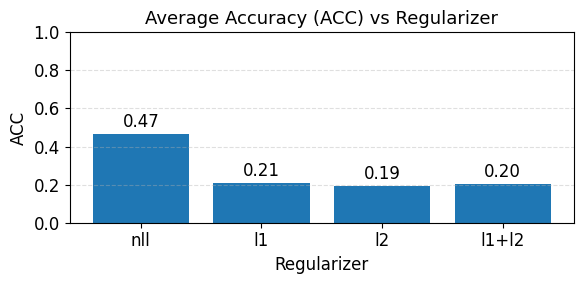

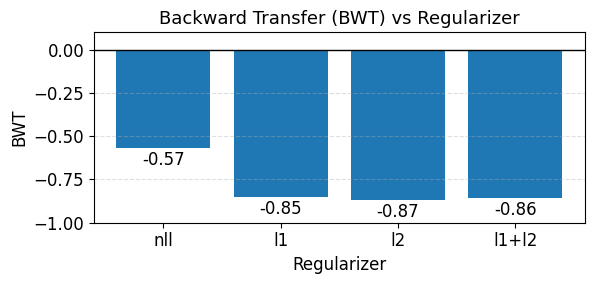

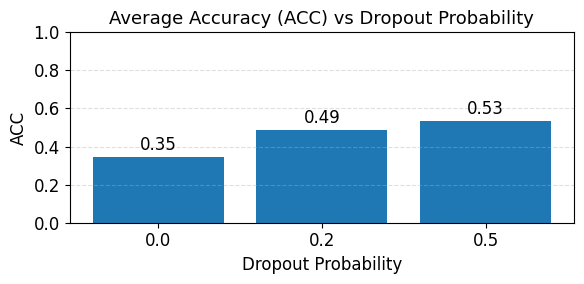

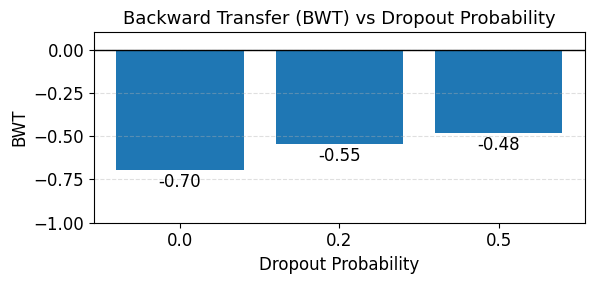

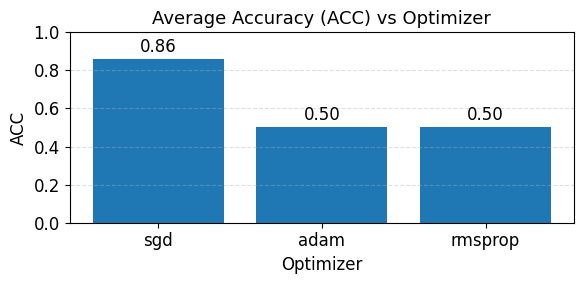

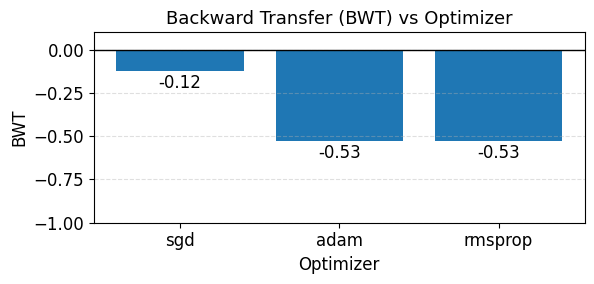

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 13,
    "axes.labelsize": 12
})

summary = pd.DataFrame([{k:v for k,v in r.items() if k != "R_"} for r in results]).sort_values("tag")
print(summary[["tag","depth","dropout_p","loss_name","opt_name","ACC","BWT"]].to_string(index=False))

TITLE_FOR = {
    "depth_":   "Network Depth",
    "dropout_": "Dropout Probability",
    "opt_":     "Optimizer",
    "reg_":     "Regularizer",
}

ORDER_FOR = {
    "opt_": ["sgd", "adam", "rmsprop"],
    "reg_": ["nll", "l1", "l2", "l1+l2"],
}

def _prep_subset(df, prefix):
    sub = df[df["tag"].str.startswith(prefix)].copy()

    parts = sub["tag"].str.split(pat="_", n=1, expand=True)
    sub["x"] = parts[1]


    if prefix == "depth_":
        sub["sort"] = sub["x"].astype(int)
        sub = sub.sort_values("sort")
    elif prefix == "dropout_":
        sub["sort"] = sub["x"].astype(float)
        sub = sub.sort_values("sort")
        sub["x"] = sub["sort"].map(lambda v: f"{v:.1f}")
    elif prefix == "opt_":
        order = ["sgd", "adam", "rmsprop"]
        sub["x"] = pd.Categorical(sub["x"], categories=order, ordered=True)
        sub = sub.sort_values("x")
    elif prefix == "reg_":
        order = ["nll", "l1", "l2", "l1+l2"]
        sub["x"] = pd.Categorical(sub["x"], categories=order, ordered=True)
        sub = sub.sort_values("x")

    return sub




def bar_for(metric, prefix):
    sub = _prep_subset(summary, prefix)
    x = sub["x"].astype(str).tolist()
    y = sub[metric].to_numpy()

    fig, ax = plt.subplots(figsize=(6,3))
    xticks = np.arange(len(x))
    bars = ax.bar(xticks, y)

    ax.set_xticks(xticks)
    ax.set_xticklabels(x)

    xlabel = TITLE_FOR.get(prefix, prefix)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(metric)
    title_left = "Backward Transfer (BWT)" if metric == "BWT" else "Average Accuracy (ACC)"
    ax.set_title(f"{title_left} vs {xlabel}")
    ax.grid(axis='y', linestyle='--', alpha=0.4)

    if metric == "BWT":
        ax.set_ylim(-1.0, 0.1)
        ax.axhline(0, color='black', linewidth=1)
    else:
        ax.set_ylim(0.0, 1.0)

    ax.bar_label(bars, labels=[f"{v:.2f}" for v in y], padding=2)
    plt.tight_layout()
    plt.show()

bar_for("ACC","depth_");   bar_for("BWT","depth_")
bar_for("ACC","reg_");     bar_for("BWT","reg_")
bar_for("ACC","dropout_"); bar_for("BWT","dropout_")
bar_for("ACC","opt_");     bar_for("BWT","opt_")


Plot the validation drop between tasks

FileNotFoundError: [Errno 2] No such file or directory: 'figs/forgetting_curves.png'

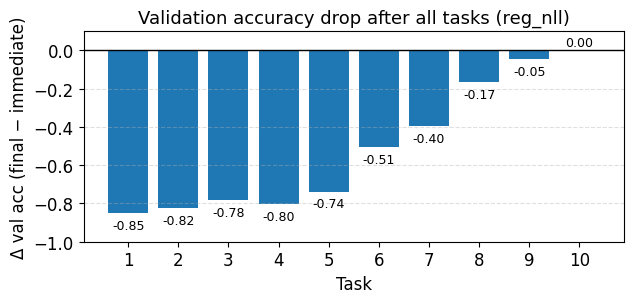

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_validation_drop_from_R(R, title="Validation accuracy drop after all 10 tasks", savepath=None):
    N = R.shape[0]
    acc_after_learn = np.array([R[i, i] for i in range(N)])
    acc_after_all   = R[-1, :N]
    delta = acc_after_all - acc_after_learn

    x = np.arange(1, N+1)

    plt.figure(figsize=(6.5, 3.2))
    bars = plt.bar(x, delta)
    plt.axhline(0, linewidth=1, color='black')
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.xlabel("Task")
    plt.ylabel("Δ val acc (final − immediate)")
    plt.title(title)
    plt.ylim(-1.0, 0.1)
    plt.xticks(x)

    for b, v in zip(bars, delta):
        plt.text(b.get_x() + b.get_width()/2, v + (0.01 if v >= 0 else -0.03),
                 f"{v:.2f}", ha='center', va='top' if v < 0 else 'bottom', fontsize=9)
    plt.tight_layout()

    if savepath:
        plt.savefig(savepath, dpi=200, bbox_inches="tight")
    plt.show()


def plot_validation_drop_for_run(results, tag_to_use=None):
    if tag_to_use is None:
        preferred = ["reg_nll", "opt_sgd", "opt_adam", "depth_3", "dropout_0.2"]
        chosen = None
        for p in preferred:
            chosen = next((r for r in results if r.get("tag") == p and "R_" in r), None)
            if chosen is not None:
                break
        if chosen is None:
            chosen = next((r for r in results if "R_" in r), None)
    else:
        chosen = next((r for r in results if r.get("tag") == tag_to_use and "R_" in r), None)

    if chosen is None:
        raise ValueError("No run with an R_ matrix found in `results`. Make sure you keep R_ when saving results.")

    R = np.asarray(chosen["R_"])
    plot_validation_drop_from_R(R, title=f"Validation accuracy drop after all tasks ({chosen['tag']})",
                                savepath="figs/forgetting_curves.png")


plot_validation_drop_for_run(results, tag_to_use="reg_nll")
